## Spatial Structure of Rain

Import the class object RainGage and initialize it with a file containing all of the data or with a list of years. The output from this are all contained in attributes of the ** `RainGage`** class. All of the data are contained in a **`pandas.DataFrame`** object called **`RainGage.df`**

In [1]:
%matplotlib inline
from raingage import *

In [2]:
path = "./input/"

In [3]:
rg = RainGage(path=path, df_file="Philadelphia_raingage_1996_2015_NAN_filled_time_indexed.dat")

In [4]:
import rpy2.robjects as robjects
from rpy2.robjects import r, pandas2ri

### Wettest times

For these semi variograms we only allow times in which all the gages record non-zero values. From those select times we pull out the largest accumultations and store them in a **`pandas.DataFrame`** object called **`RainGage.wettest`**. This dataframe is the transpose of earlier dataframes and includes both euclidian and latlon coordinates for each rain gage.  

In [5]:
rg.get_wettest()

In [6]:
rg.wettest.head()

,RG,lon,lat,Y,X,2011-04-17 01:00:00,2011-04-17 01:15:00,2011-08-14 10:45:00,2013-08-13 12:30:00,2013-08-13 12:15:00
RG,,,,,,,,,,
RG3,RG3,-75.223174,39.906295,1.849172,1.740343,4.318,9.652,8.128,15.240,15.240
RG5,RG5,-75.239724,39.927582,4.202980,2.323897,7.874,10.160,9.398,9.906,11.176
RG21,RG21,-75.051952,40.067225,19.643893,31.441358,7.874,2.540,2.032,4.826,6.858
RG16,RG16,-74.997889,40.042669,16.928592,33.744476,10.922,8.636,18.542,5.588,12.192
RG4,RG4,-75.150782,39.924150,3.823488,9.594946,3.302,5.080,9.144,11.938,8.128


You will notice that we have a new SVG_data file saved in our home dir. This was created within the get_wettest function. This file will be used as input to the semivariogram calculation in r. You can set the keyword arguments for the r function by changing the values within the quotes.

In [7]:
# run r commands to get the SVG
foo = r('SVG_data = read.table("./SVG_data", sep=",",header = TRUE) \n' +
        'source("SVG.r") \n'+
        'SVG_tab <- get_SVG(SVG_data, last_max=TRUE, cressie=TRUE)\n'
        )
df = pd.DataFrame(robjects.numpy2ri.ri2numpy(robjects.globalenv['SVG_tab']))
df.index = df.dist
names=['np', 'dist']
for t in rg.wettest.columns[5::]:
    names.append(t)
df.columns = names

And you can plot the output right here in the notebook:

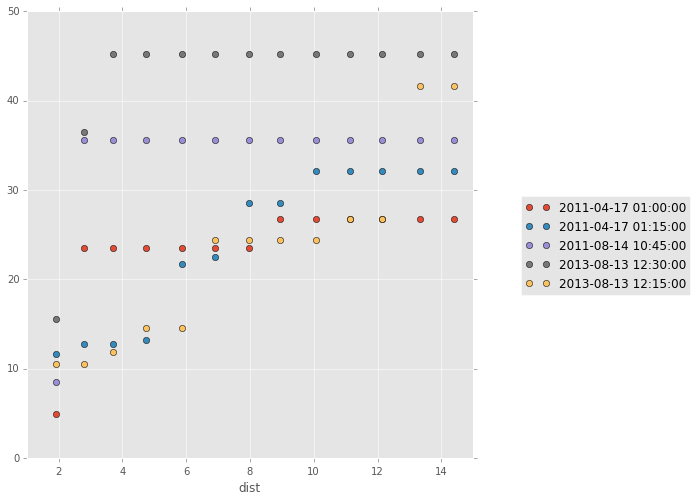

In [8]:
df[range(2,len(df.columns))].plot(style='o', figsize=(8, 8), xlim=(1,15), legend=False)
plt.legend(bbox_to_anchor=(1.5, 0.6))
plt.show()

### A particular storm

This operates similarly to the wettest section, but for these semi variograms we are interested in tracking a timespan, such as one particular storm. To this end, we allow times in which some gages record zeros. Again, we pull out the times of interest and store them in a **`pandas.DataFrame`** object called **`RainGage.storm`**. This dataframe is the transpose of earlier dataframes and includes both euclidian and latlon coordinates for each rain gage.  

In [9]:
rg.get_storm('2013-08-13')

In [11]:
rg.storm.head()

,RG,lon,lat,Y,X,2013-08-13 09:15:00,2013-08-13 09:30:00,2013-08-13 09:45:00,2013-08-13 10:00:00,2013-08-13 10:15:00,...,2013-08-13 11:30:00,2013-08-13 11:45:00,2013-08-13 12:00:00,2013-08-13 12:15:00,2013-08-13 12:30:00,2013-08-13 12:45:00,2013-08-13 13:00:00,2013-08-13 13:15:00,2013-08-13 13:30:00,2013-08-13 13:45:00
RG,,,,,,,,,,,,,,,,,,,,,
RG3,RG3,-75.223174,39.906295,1.849172,1.740343,0.254,0.762,0.508,1.524,0.254,...,0.762,0.762,0.762,15.240,15.240,3.556,1.778,0.254,0.762,0.254
RG5,RG5,-75.239724,39.927582,4.202980,2.323897,0.254,1.270,1.016,0.000,0.000,...,0.254,0.762,5.334,11.176,9.906,3.810,0.000,0.508,0.254,0.254
RG21,RG21,-75.051952,40.067225,19.643893,31.441358,1.270,0.762,2.032,0.254,0.762,...,19.812,5.842,8.382,6.858,4.826,2.032,1.524,0.762,0.000,0.000
RG16,RG16,-74.997889,40.042669,16.928592,33.744476,1.016,1.778,1.016,0.254,0.000,...,0.254,1.016,8.382,12.192,5.588,5.080,0.000,0.000,0.762,0.254
RG4,RG4,-75.150782,39.924150,3.823488,9.594946,0.254,0.762,1.270,1.270,0.000,...,0.508,0.762,0.254,8.128,11.938,3.810,2.032,0.000,0.254,1.016


Since the number of gages for each time is not consistant, we need to calculate the number of interdistances (np) to make sure that we have about 30 in each bin. So we calculate the semivariogram for each site separately and then aggregate the results

In [12]:
s = {}
d = {}
for i, col in enumerate(rg.storm):
    if col not in rg.RG_lon_lat.columns:
        foo = r('SVG_data = read.table("./SVG_data", sep=",",header = TRUE) \n' +
                'source("SVG.r") \n'+
                'iSVG_tab <- get_iSVG(SVG_data, {index}, target_np=5, alpha=46.5, tol.hor=20, last_max=TRUE, cressie=FALSE)\n'.format(index=i+1)
                )
        df = pd.DataFrame(robjects.numpy2ri.ri2numpy(robjects.globalenv['iSVG_tab']))
        try:
            df.index = df.dist
        except:
            continue
        d.update({col: df})
        s.update({col: (df['gamma'].idxmax(axis=0), df['np'].sum())})
df = pd.DataFrame(s).transpose()
df.columns=['dist', 'np']

We have access to the raw results by looking inside the **`dictionary`** called **`d`**. This contains all of the variograms with the times at which they occur as the keys. These keys are **`pandas.Timestamp`** objects, so we can call flexibly as shown below. Note that they are not ordered.

In [20]:
d.keys()[0:2]

[Timestamp('2013-08-13 11:30:00'), Timestamp('2013-08-13 11:15:00')]

In [21]:
d[pd.Timestamp('2013-08-13 11:30')]

,np,dist,gamma,dir.hor,dir.ver,id
dist,,,,,,
6.432199,29,6.432199,56.793103,46.5,0,1
12.357241,30,12.357241,85.483333,46.5,0,1
18.107494,29,18.107494,85.483333,46.5,0,1
24.670647,32,24.670647,85.483333,46.5,0,1
34.198009,30,34.198009,85.483333,46.5,0,1
44.988698,3,44.988698,85.483333,46.5,0,1


If we prefer to see the plot of the aggregated results:

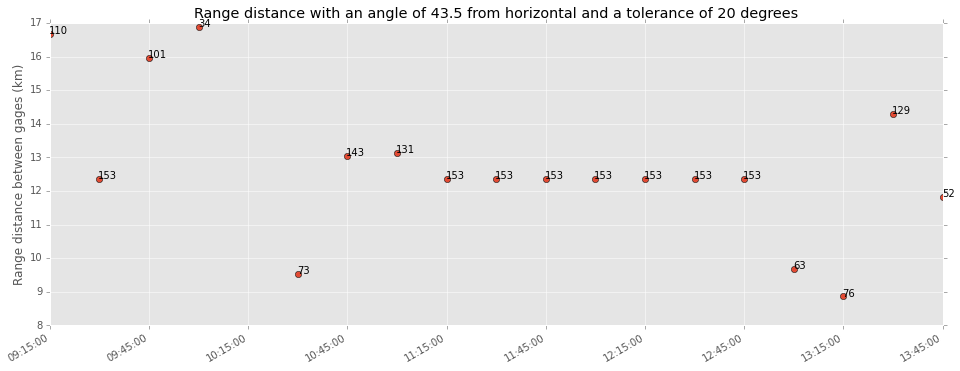

In [13]:
ax = df['dist'].plot(figsize=(16,6), style='o')
plt.ylabel('Range distance between gages (km)')
plt.title('Range distance with an angle of 43.5 from horizontal and a tolerance of 20 degrees')
for i, val in enumerate(df['dist']):
    ax.annotate(s = int(df['np'][i]), xy=(df['dist'].index[i], val))
plt.savefig('./output/2013-08-13 range with angle 43.jpg')
plt.show()

### Rainiest Days

This is an attempt to look at the rainiest days using a similar method to that described above. The first step is to select the days.  A straightforward approach is to compute the mean daily rainfall (with a day defined from 12 UTC to 12 UTC to reflect the diurnal cycle of rainfall, especially for the warm season) as the average of all rain gage observations for stations that are active and just rank the days.

In [23]:
daily = rg.rate.resample('24H', base=12, how='mean',label='right', closed='right')

We focus on the largest n days, where n is in the vicinity of 50.

In [24]:
largest = daily.mean(axis=1).sort_values().tail(50)
largest.tail()

date_time
2005-10-09 12:00:00    3.727097
2007-04-16 12:00:00    3.787951
2010-10-01 12:00:00    3.820207
2004-09-29 12:00:00    4.928306
2011-08-28 12:00:00    5.931958
dtype: float64

In [25]:
rainiest = daily.loc[largest.index]

Another way of picking the largest days is to rank the days by maximum daily rainfall at any gage location.  

In [85]:
##TODO

Semi-variograms would provide one useful way of characterizing spatial structure.  It would also be useful to examine mean rainfall for the 50 events at each of the 24 stations.

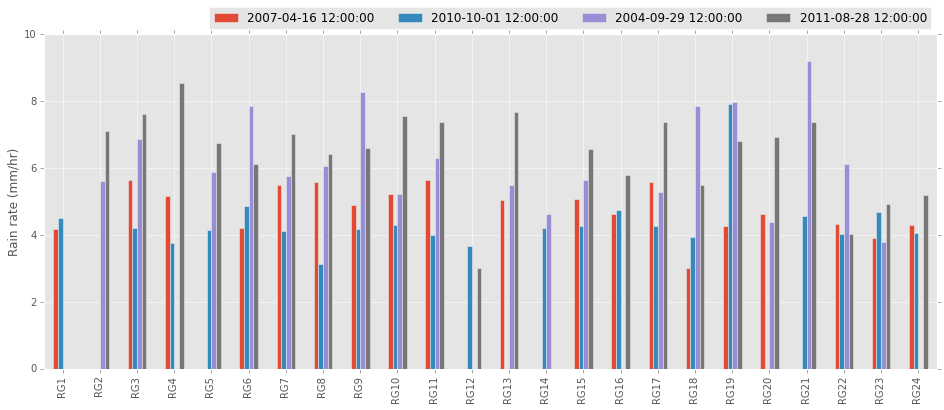

In [26]:
rainiest.iloc[range(46, 50)].transpose().plot( kind='bar', figsize=(16,6))
plt.legend(bbox_to_anchor=(1, 1.1), ncol = 5)
plt.ylabel('Rain rate (mm/hr)')
plt.savefig('./output/Rates for rainiest 4 days.jpg')
plt.show()

Now we can make a semi variogram of the rainiest days

In [27]:
rg.get_RG_lon_lat()

In [28]:
storm = rainiest.transpose()

In [29]:
storm = rg.RG_lon_lat.join(storm)
for col in storm:
    if col not in rg.RG_lon_lat.columns:
        storm[col] = storm[col].replace(0, np.nan)
storm.to_csv('SVG_data', index=False)

In [60]:
d = {}
bar = {}
for i, col in enumerate(storm):
    if col not in rg.RG_lon_lat.columns:
        foo = r('SVG_data = read.table("./SVG_data", sep=",",header = TRUE) \n' +
                'source("SVG.r") \n'+
                'iSVG_tab <- get_iSVG(SVG_data, {index}, target_np=30, alpha=0, tol.hor=90, last_max=FALSE, cressie=FALSE)\n'.format(index=i+1)
                )
        df = pd.DataFrame(robjects.numpy2ri.ri2numpy(robjects.globalenv['iSVG_tab']))
        try:
            df.index = df.dist
        except:
            continue
        d.update({col: df[:]})
        df.columns = ['np', 'dist', col, 'dir.hor', 'dir.vert', 'id']
        s = df[col]
        bar.update({col: s})
plotting_df = pd.DataFrame(bar.values()).transpose()

In [61]:
d[pd.Timestamp('2012-10-30 12')].head()

,np,dist,gamma,dir.hor,dir.ver,id
dist,,,,,,
2.677316,13,2.677316,33.346154,0,0,1
5.075134,31,5.075134,37.709677,0,0,1
7.709026,34,7.709026,35.323529,0,0,1
9.995967,26,9.995967,62.730769,0,0,1
12.559935,30,12.559935,75.316667,0,0,1


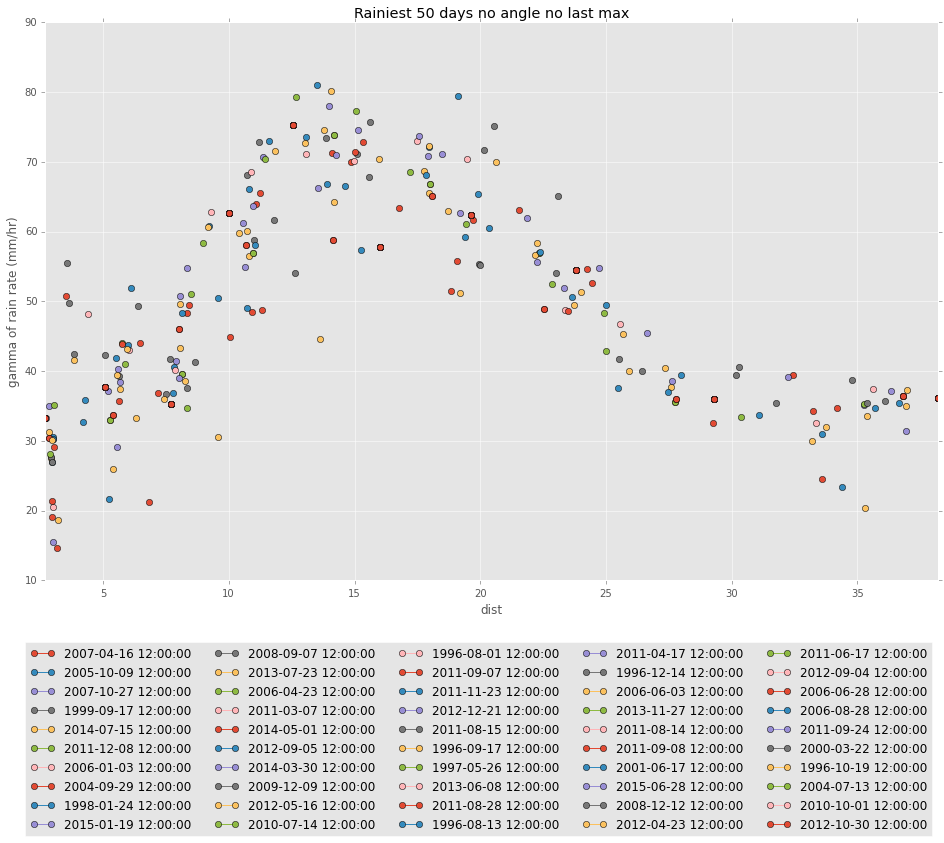

In [62]:
title = 'Rainiest 50 days no angle no last max'

plotting_df.plot(marker = 'o', figsize=(16,10))
plt.ylabel('gamma of rain rate (mm/hr)'),
plt.legend(bbox_to_anchor=(1, -.1), ncol = 5)
plt.title(title)
plt.savefig('./output/{title}.jpg'.format(title=title))
plt.show()

Plot them up on a map so that you can see where the high values are

In [358]:
storm = rainiest.iloc[range(46, 50)].transpose()
storm = rg.RG_lon_lat.join(storm)

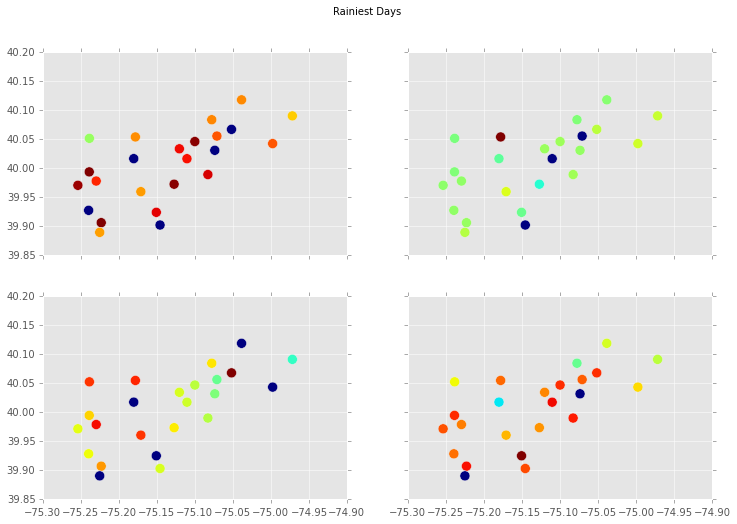

In [359]:
f, ax_ar = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(12,8))
f.suptitle('Rainiest Days')
plt.jet()
ax_ar[0][0].scatter(x=storm['lon'], y=storm['lat'], c=storm[[5]], s=100)
ax_ar[0][1].scatter(x=storm['lon'], y=storm['lat'], c=storm[[6]], s=100)
ax_ar[1][0].scatter(x=storm['lon'], y=storm['lat'], c=storm[[7]], s=100)
ax_ar[1][1].scatter(x=storm['lon'], y=storm['lat'], c=storm[[8]], s=100)
plt.show()